Conditional Variational Auto-encoder that generates MNIST numbers given the number label.

Linear operations apply affine transform $y = x A^T + b$. Documentation for `torch.nn.Linear()`:  
<https://pytorch.org/docs/stable/generated/torch.nn.Linear.html>

Based on code from:  
<https://github.com/timbmg/VAE-CVAE-MNIST>


In [38]:
import os
import time
import argparse
from collections import defaultdict

import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision
from tqdm import tqdm

plt.rcParams['figure.dpi'] = 100

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [2]:
def idx2onehot(idx, n):
    assert torch.max(idx).item() < n
    if idx.dim() == 1:
        idx = idx.unsqueeze(1)
    onehot = torch.zeros(idx.size(0), n).to(idx.device)
    onehot.scatter_(1, idx, 1)
    return onehot

class CVAE(nn.Module):
    def __init__(self, encoder_layer_sizes, latent_size, decoder_layer_sizes, num_labels):
        super().__init__()
        assert type(encoder_layer_sizes) == list
        assert type(latent_size) == int
        assert type(decoder_layer_sizes) == list
        self.latent_size = latent_size
        self.encoder = Encoder(encoder_layer_sizes, latent_size, num_labels)
        self.decoder = Decoder(decoder_layer_sizes, latent_size, num_labels)

    def forward(self, x, c=None):
        if x.dim() > 2:
            x = x.view(-1, 28*28)
        means, log_var = self.encoder(x, c)
        z = self.reparameterize(means, log_var)
        recon_x = self.decoder(z, c)
        return recon_x, means, log_var, z

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def inference(self, z, c=None):
        recon_x = self.decoder(z, c)
        return recon_x


class Encoder(nn.Module):
    def __init__(self, layer_sizes, latent_size, num_labels):
        super().__init__()
        layer_sizes[0] += num_labels
        self.MLP = nn.Sequential()
        for i, (in_size, out_size) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
            self.MLP.add_module(
                name="L{:d}".format(i), module=nn.Linear(in_size, out_size))
            self.MLP.add_module(name="A{:d}".format(i), module=nn.ReLU())
        self.linear_means = nn.Linear(layer_sizes[-1], latent_size)
        self.linear_log_var = nn.Linear(layer_sizes[-1], latent_size)

    def forward(self, x, c=None):
        c = idx2onehot(c, n=10)
        x = torch.cat((x, c), dim=-1)
        x = self.MLP(x)
        means = self.linear_means(x)
        log_vars = self.linear_log_var(x)
        return means, log_vars


class Decoder(nn.Module):
    def __init__(self, layer_sizes, latent_size, num_labels):
        super().__init__()
        self.MLP = nn.Sequential()
        input_size = latent_size + num_labels
        for i, (in_size, out_size) in enumerate(zip([input_size]+layer_sizes[:-1], layer_sizes)):
            self.MLP.add_module(
                name="L{:d}".format(i), module=nn.Linear(in_size, out_size))
            if i+1 < len(layer_sizes):
                self.MLP.add_module(name="A{:d}".format(i), module=nn.ReLU())
            else:
                self.MLP.add_module(name="sigmoid", module=nn.Sigmoid())

    def forward(self, z, c):
        c = idx2onehot(c, n=10)
        z = torch.cat((z, c), dim=-1)
        x = self.MLP(z)
        return x

In [3]:
args = AttrDict(epochs=20, batch_size=128, learning_rate=0.001,
        encoder_layer_sizes=[784, 512], decoder_layer_sizes=[512, 784],
        latent_size=2, print_every=100, fig_root='figs')

# torch.manual_seed(args.seed)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed(args.seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = torchvision.datasets.MNIST(
    root='./data', transform=torchvision.transforms.ToTensor(), download=True)
data = torch.utils.data.DataLoader(dataset, batch_size=args.batch_size, shuffle=True)

/home/fireofearth/.local/miniconda3/envs/trajectron-cplex/lib/python3.6/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Training epoch 19 (loss  130.6204): : 100%|██████████| 469/469 [00:09<00:00, 47.55it/s]


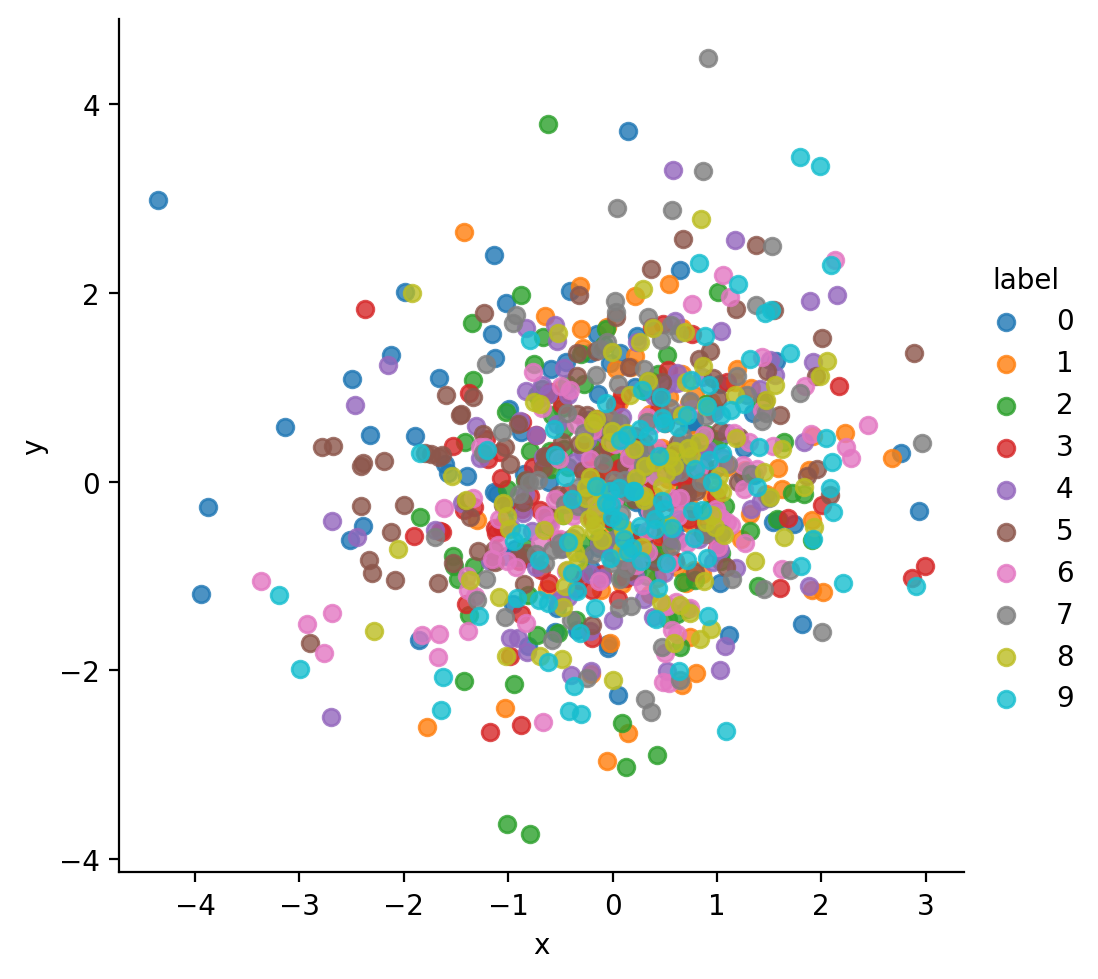

In [4]:
logs = defaultdict(list)

def loss_fn(recon_x, x, mean, log_var):
    BCE = torch.nn.functional.binary_cross_entropy(
        recon_x.view(-1, 28*28), x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return (BCE + KLD) / x.size(0)

def train(cvae, data, epochs=5):
    optimizer = torch.optim.Adam(cvae.parameters(), lr=args.learning_rate)
    ts = time.time()
    
    for epoch in range(epochs):
        tracker_epoch = defaultdict(lambda: defaultdict(dict))
        prefix = f"Training Epoch {epoch}: "
        pbar = tqdm(data, desc=prefix, 
                dynamic_ncols=True, leave=True, position=0)
        for iteration, (x, y) in enumerate(pbar):
            x, y = x.to(device), y.to(device)
            recon_x, mean, log_var, z = cvae(x, y)
            for i, yi in enumerate(y):
                id = len(tracker_epoch)
                tracker_epoch[id]['x'] = z[i, 0].item()
                tracker_epoch[id]['y'] = z[i, 1].item()
                tracker_epoch[id]['label'] = yi.item()
            loss = loss_fn(recon_x, x, mean, log_var)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            logs['loss'].append(loss.item())
            if iteration % args.print_every == 0 or iteration == len(data)-1:
                pbar.set_description("Training epoch {} (loss {:9.4f}): ".format(epoch, loss.item()))
                pbar.update()
                c = torch.arange(0, 10).long().unsqueeze(1).to(device)
                z = torch.randn([c.size(0), args.latent_size]).to(device)
                x = cvae.inference(z, c=c)
                plt.figure()
                plt.figure(figsize=(5, 10))
                for p in range(10):
                    plt.subplot(5, 2, p+1)
                    plt.text(
                        0, 0, "c={:d}".format(c[p].item()), color='black',
                        backgroundcolor='white', fontsize=8)
                    plt.imshow(x[p].view(28, 28).cpu().data.numpy())
                    plt.axis('off')
                if not os.path.exists(os.path.join(args.fig_root, str(ts))):
                    if not(os.path.exists(os.path.join(args.fig_root))):
                        os.mkdir(os.path.join(args.fig_root))
                    os.mkdir(os.path.join(args.fig_root, str(ts)))
                plt.savefig(
                    os.path.join(args.fig_root, str(ts),
                                 "E{:d}I{:d}.png".format(epoch, iteration)),
                    dpi=300)
                plt.clf()
                plt.close('all')
        df = pd.DataFrame.from_dict(tracker_epoch, orient='index')
        g = sns.lmplot(
            x='x', y='y', hue='label', data=df.groupby('label').head(100),
            fit_reg=False, legend=True)
        g.savefig(os.path.join(
            args.fig_root, str(ts), "E{:d}-Dist.png".format(epoch)),
            dpi=300)
    return cvae

cvae = CVAE(
        encoder_layer_sizes=args.encoder_layer_sizes,
        latent_size=args.latent_size,
        decoder_layer_sizes=args.decoder_layer_sizes,
        num_labels=10).to(device)
should_create_new_instance = False
if should_create_new_instance:
    cvae = train(cvae, data, epochs=20)
    torch.save(cvae.state_dict(), './models/cvae-2.pth')
else:
    cvae.load_state_dict(torch.load('./models/cvae-2.pth'))

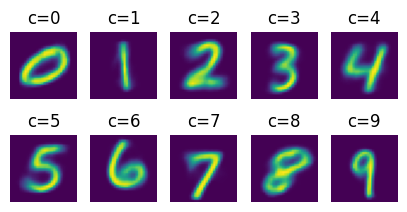

In [39]:
# c is shape (10,) 
c = torch.arange(0, 10).long().to(device)
# z is shape (10, 2)
z = torch.randn([c.size(0), args.latent_size]).to(device)
# x is shape (10, 784)
x = cvae.inference(z, c=c)

fig, axes = plt.subplots(2, 5, figsize=(5,2.5))
axes = axes.ravel()
for p in range(10):
    img = x[p].view(28, 28).cpu().detach().numpy()
    axes[p].imshow(img)
    axes[p].set_title("c={:d}".format(c[p].item()))
    axes[p].axis('off')

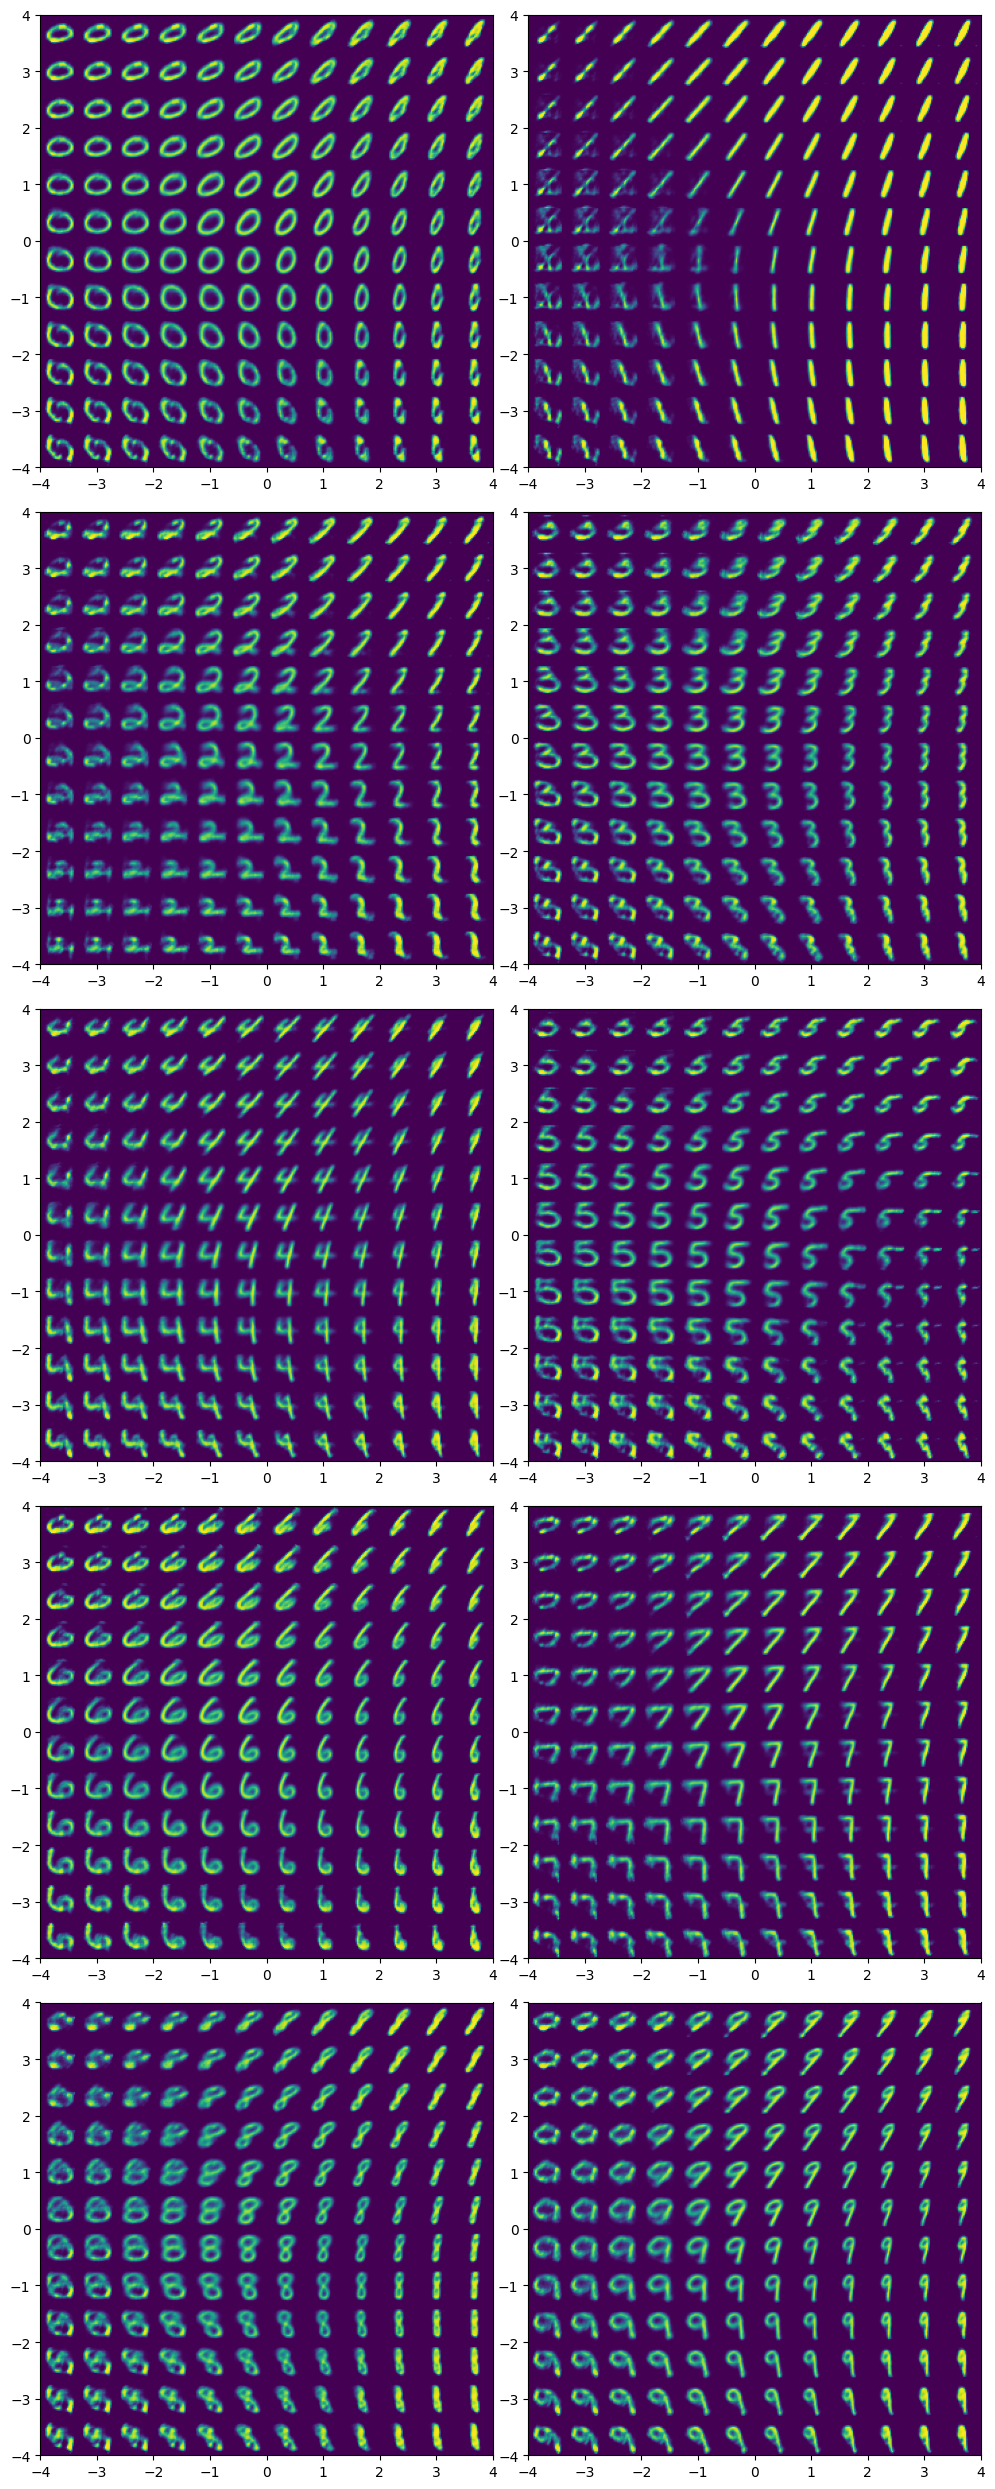

In [43]:
def plot_reconstructed(ax, cvae, label, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    c = torch.Tensor([label]).long().to(device)
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = cvae.inference(z, c=c)
            x_hat = x_hat.reshape(28, 28).cpu().detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    ax.imshow(img, extent=[*r0, *r1])

fig, axes = plt.subplots(5, 2, figsize=(10, 25))
axes = axes.ravel()
for idx, ax in enumerate(axes):
    plot_reconstructed(ax, cvae, idx, r0=(-4, 4), r1=(-4, 4))
fig.tight_layout()